<a target="_blank" href="https://colab.research.google.com/github/C22-PS186-Bangkit-2022-Capstone-Team/Relic-Classifier/blob/main/RelicClassifier.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Dinara: Indonesian Relic and Landmark Classifier

Dinara is a Bangkit 2022 Capstone Project created by 
C22-PS186 Machine Learning Team for classifying some of the most famous relic and landmark in Indonesia.    

Though the dataset trained/retrained is currently private, we are actively working to make the dataset public as soon as possible and hoped you can learn new things from our projects. This notebook was intially ran on Google Collaboratory but models, source code, app for deployment, and more can be found in our [GitHub Repository](https://github.com/C22-PS186-Bangkit-2022-Capstone-Team/Relic-Classifier), please drop a ✨star✨ in our project if you are dropping by as well 😊. 

---

C22-PS186 Machine Learning Team
- M7012F1327 - Adisa Salsha Bhiesa - Universitas Telkom
- M2320F2799 - Kenneth Manuel Lieyanto - Universitas Surabaya
- M2006H0562 - Fathimah Yasmin - Universitas Brawijaya

## Setting up

In [1]:
# Mount to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
%cd "/content/drive/MyDrive/Bangkit Capstone Project"

/content/drive/MyDrive/Bangkit Capstone Project


In [52]:
data_dir = 'Dataset'

In [53]:
import os

# Show relic/landmark that currently can be classified
labels = os.listdir(data_dir)
for label in labels:
  print(label)

Candi Brahu
Candi Mendut
Candi Prambanan
Monumen Jogja Kembali
Tugu Yogyakarta
Candi Borobudur
Monumen Solidaritas Asia Afrika
Monumen Jalesveva Jayamahe
Monumen Simpang Lima Gumul
Monumen Jayandaru
Monumen Serangan Umum 1 Maret
Monumen Bambu Runcing
Monumen Bajra Sandhi
Monumen Panca Benua
Monumen Bandung Lautan Api
Monumen Pers Nasional
Monumen Rawa Gede
Tugu Khatulistiwa
Monumen Nasional
Gedung Gonggong
Monumen Perjuangan Rakyat (Palembang)
Monumen Pattimura
Monumen Tirosa
Monumen Merpati Perdamaian
Tugu Keris Siginjai
Tugu 0 KM Indonesia
Monumen Mandala
Monumen Nani Wartabone
Monumen Palagan


## Remove dodgy images

Some of gathered images are not in the correct format, this section make sure dataset that will be trained are in the correct ones

In [54]:
import cv2
import imghdr
import os

In [55]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [56]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

## Load data

In [57]:
import tensorflow as tf

In [71]:
ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(150,150),
    class_names=labels,
    batch_size=32,
    label_mode='int'
)

Found 4812 files belonging to 29 classes.


## Brief overview on the images

In [72]:
import numpy as np

In [73]:
# Using numpy iterator so we can take one batch for example
ds_iterator = ds.as_numpy_iterator()

# Take one batch for example
# Batch will be a tuple of two items with first item representing the image
# while the second item will represent the labels
# batch[0] is an array consisting the actual images itself, while
# batch[1] is an array consisting of the label
batch = ds_iterator.next()

In [74]:
# This will also means batch[0] shape will be the input shape of our models
print(batch[0].shape) 
print(batch[1].shape)

(32, 150, 150, 3)
(32,)


In [75]:
# Show relic / landmark / monument that can be classified
for label in ds.class_names:
  print(label)

Candi Brahu
Candi Mendut
Candi Prambanan
Monumen Jogja Kembali
Tugu Yogyakarta
Candi Borobudur
Monumen Solidaritas Asia Afrika
Monumen Jalesveva Jayamahe
Monumen Simpang Lima Gumul
Monumen Jayandaru
Monumen Serangan Umum 1 Maret
Monumen Bambu Runcing
Monumen Bajra Sandhi
Monumen Panca Benua
Monumen Bandung Lautan Api
Monumen Pers Nasional
Monumen Rawa Gede
Tugu Khatulistiwa
Monumen Nasional
Gedung Gonggong
Monumen Perjuangan Rakyat (Palembang)
Monumen Pattimura
Monumen Tirosa
Monumen Merpati Perdamaian
Tugu Keris Siginjai
Tugu 0 KM Indonesia
Monumen Mandala
Monumen Nani Wartabone
Monumen Palagan


## Preprocessing

In [76]:
def normalize_img(image, label):
  return tf.cast(image, tf.float32)/255.0, label

In [77]:
# Apply normalization
ds = ds.map(normalize_img)

scaled_iterator = ds.as_numpy_iterator()
batch = scaled_iterator.next()
# After normalization batch[0] that contain the actual images itself should 
# the maximum value of 1 and minimum value of 0
print(batch[0].max())
print(batch[0].min())

1.0
0.0


## Paritioning

In [78]:
train_size = int(len(ds)*.8)
val_size = int(len(ds)*.1) + 1
test_size = int(len(ds)*.1)

In [79]:
# Make sure that dataset batch length should be the same value with the total of
# train, validation, and test size
print(len(ds))
print(train_size + val_size + test_size)

151
151


In [80]:
# Seperate batches for training, validation, and test set
train = ds.take(train_size)
val = ds.skip(train_size).take(val_size)
test = ds.skip(train_size+val_size).take(test_size)

## Basic model creation

Our team initially used only 6 classes for experiment to see if we can make our own models from scratch and it did reach pretty good result with both training, validation, and test set reaching ~90% accuracy with both precision and recall also around ~90%. But as we keep adding more and more dataset (and classes) to classify, our model seems to overfit and experimenting with prepreprocessing, hyperparameters, or the model layer itself seems to be inefficient as we were able to reach validation accuracy of only ~70% with the model belows. 

With that said We then decided to try use pretrained model from keras application to see if we can get a better result with it.

Please also note that output of this part of the project is purposedly cleared because of the stated reason above

In [28]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3))) 
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3))) 
model.add(MaxPooling2D(pool_size = (2, 2), strides = None, padding = 'valid', data_format = None)) 
model.add(Dropout(0.25)) 
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3))) 
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu', input_shape = (150, 150, 3))) 
model.add(MaxPooling2D(pool_size = (2, 2), strides = None, padding = 'valid', data_format = None))
model.add(Dropout(0.25)) 
model.add(Flatten()) 
model.add(Dense(256))
model.add(Dense(15, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard()

In [ ]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

### Model evaluation

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = np.max(model.predict(X), axis=-1)
  ypred = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, ypred)

In [ ]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.9424084, shape=(), dtype=float32) tf.Tensor(0.95238096, shape=(), dtype=float32) tf.Tensor(0.69154227, shape=(), dtype=float32)


### Saving model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('drive/MyDrive', 'experimentalmodel.h5'))

## Model creation with pretrained models

In [81]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [82]:
base_model = Xception(weights='imagenet', input_shape=(150,150,3), include_top=False, pooling='avg')

x = base_model.output

x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)
x = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False

In [83]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 74, 74, 32)   864         ['input_4[0][0]']                
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 74, 74, 32)  128         ['block1_conv1[0][0]']           
 ation)                                                                                           
                                                                                            

In [84]:
#Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [85]:
tensorboard_callback = tf.keras.callbacks.TensorBoard()

In [87]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
120/120 [==============================] - 38s 300ms/step - loss: 2.6182 - accuracy: 0.2714 - val_loss: 1.9358 - val_accuracy: 0.4785
Epoch 2/25
120/120 [==============================] - 38s 313ms/step - loss: 1.8012 - accuracy: 0.5193 - val_loss: 1.4160 - val_accuracy: 0.6367
Epoch 3/25
120/120 [==============================] - 38s 313ms/step - loss: 1.4204 - accuracy: 0.6057 - val_loss: 1.1969 - val_accuracy: 0.7031
Epoch 4/25
120/120 [==============================] - 36s 292ms/step - loss: 1.1884 - accuracy: 0.6701 - val_loss: 1.0735 - val_accuracy: 0.7324
Epoch 5/25
120/120 [==============================] - 36s 293ms/step - loss: 1.0472 - accuracy: 0.7115 - val_loss: 1.0369 - val_accuracy: 0.7344
Epoch 6/25
120/120 [==============================] - 39s 315ms/step - loss: 0.9579 - accuracy: 0.7302 - val_loss: 0.9885 - val_accuracy: 0.7305
Epoch 7/25
120/120 [==============================] - 37s 304ms/step - loss: 0.8506 - accuracy: 0.7560 - val_loss: 0.9488 - val_ac

### Model evaluation

The last iteration of adding dataset was from 16 classes to 29 classes, previously we actualy did reach 90% accuracy, both on training, validation, and testing with precision and recall above 90% as well. So the model now seems a little bit overfit but still pretty good.

In [93]:
from matplotlib import pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy

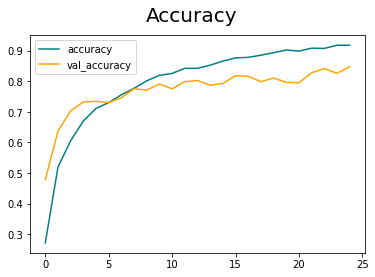

In [90]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

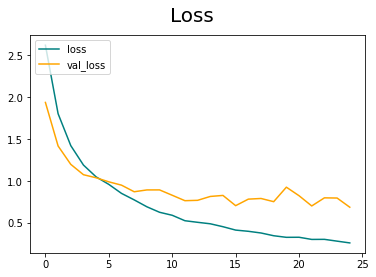

In [92]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [95]:
pre = Precision()
re = Recall()
acc = SparseCategoricalAccuracy()

for batch in test.as_numpy_iterator():
  X, y = batch
  yhat = np.max(model.predict(X), axis=-1)
  ypred = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, ypred)

In [96]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.96029776, shape=(), dtype=float32) tf.Tensor(0.87358916, shape=(), dtype=float32) tf.Tensor(0.7804348, shape=(), dtype=float32)


In [151]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [131]:
y_test = np.array([])
y_pred = np.array([])
for batch in test.as_numpy_iterator():
  X, y = batch
  y_test = np.concatenate([y_test, y])
  y_pred_batch = model.predict(X)
  for prob in y_pred_batch:
    classes = int(prob.argmax(axis=-1))
    y_pred = np.append(y_pred, classes)

(<Figure size 864x864 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8cd95a8c90>)

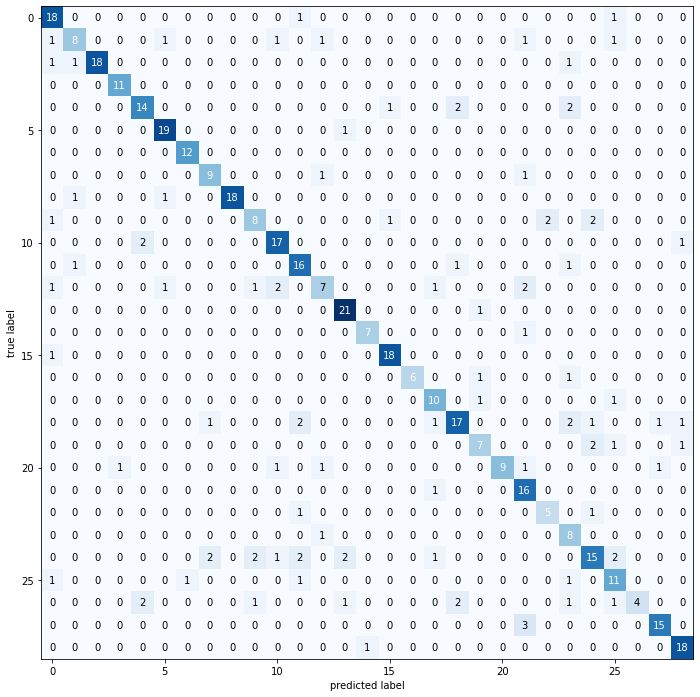

In [153]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(12,12))

### Testing on new data

In [155]:
from google.colab import files
from tensorflow.keras.applications.xception import preprocess_input
from matplotlib import pyplot as plt

In [156]:
%cd /content

/content


Saving borobudur.jpeg to borobudur.jpeg
borobudur.jpeg
Candi Borobudur


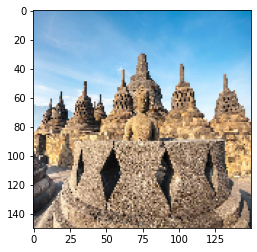

In [158]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
 
  images = np.vstack([x])
  prob = model.predict(images)[0]
  classes = int(prob.argmax(axis=-1))
  
  print(fn)
  print(labels[classes])

### Saving model

In [159]:
from tensorflow.keras.models import load_model

In [160]:
model.save(os.path.join('drive/MyDrive', 'xception_relic_classifier.h5'))

## Using a saved model

In [162]:
%cd '/content/drive/MyDrive'

/content/drive/MyDrive


In [164]:
from tensorflow import keras
model = keras.models.load_model('xception_relic_classifier.h5')

### Testing on new data with saved models

In [168]:
%cd /content

/content


Saving monas.jpeg to monas.jpeg
(1, 150, 150, 3)
monas.jpeg
Monumen Nasional


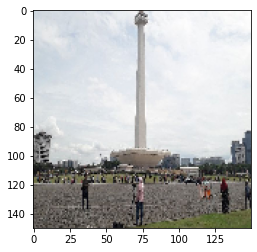

In [170]:
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  print(x.shape)
  x = preprocess_input(x)
 
  images = np.vstack([x])
  prob = model.predict(images)[0]
  classes = int(prob.argmax(axis=-1))
  
  print(fn)
  print(labels[classes])